In [1]:
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt
from zipfile import ZipFile
import scipy.misc
import cv2
from PIL import Image
from IPython.display import display

In [2]:
np.random.seed(0)
plt.rcParams['image.cmap'] = 'gray'
train_test_split = 0.1 # fraction used for test set

In [3]:
category = 'spray'
src_parent_path = os.path.join('raw_data', category)
dest_parent_path = os.path.join('sets_labels', 'category_wise', category)

orig_path = os.path.join(src_parent_path, 'original.zip')
light_perturbed_path = os.path.join(src_parent_path,'perturbed_light.zip')
occl_perturbed_path = os.path.join(src_parent_path,'perturbed_occl.zip')
orig_gt_path = os.path.join(src_parent_path,'original_GT','original_GT.csv')
light_gt_path = os.path.join(src_parent_path,'perturbed_light_GT','light_perturbed_GT.csv')
occl_gt_path = os.path.join(src_parent_path,'perturbed_occl_GT','occl_perturbed_GT.csv')

train_set_path = os.path.join(dest_parent_path, 'partial_train_set.hdf5')
train_label_path = os.path.join(dest_parent_path, 'partial_train_labels.hdf5')
test_set_path = os.path.join(dest_parent_path, 'partial_test_set.hdf5')
test_label_path = os.path.join(dest_parent_path, 'partial_test_labels.csv')

In [4]:
orig_arc = ZipFile(orig_path, 'r')
light_arc = ZipFile(light_perturbed_path, 'r')
occl_arc = ZipFile(occl_perturbed_path, 'r')
orig_gt = np.loadtxt(orig_gt_path, dtype = np.float32)[1:]
light_gt = np.loadtxt(light_gt_path, dtype = np.float32)
occl_gt = np.loadtxt(occl_gt_path, dtype = np.float32)
print(orig_gt.shape)
print(light_gt.shape)
print(occl_gt.shape)

(2999, 6)
(1000, 6)
(1000, 6)


In [5]:
orig_fnames = orig_arc.namelist()[1:]
light_fnames = light_arc.namelist()[1:]
occl_fnames = occl_arc.namelist()[1:]
print(len(orig_fnames))
print(len(light_fnames))
print(len(occl_fnames))
num_orig_img_train = int(len(orig_fnames) * (1 - train_test_split)) # first num_orig_img_train will be in train set, rest in test
num_light_img_train = int(len(light_fnames) * (1 - train_test_split)) # same as above
num_occl_img_train = int(len(occl_fnames) * (1 - train_test_split)) # same as above
print(num_orig_img_train)
print(num_light_img_train)
print(num_occl_img_train)

2999
1000
1000
2699
900
900


In [6]:
w, h = 128, 128

(128, 128)


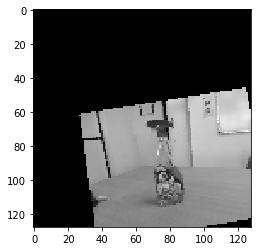

In [7]:
# sanity check to see if the folder is being read
ifile = orig_arc.open(orig_fnames[0])
img = Image.open(ifile)
img = img.resize((w,h))
img = np.array(img, dtype=np.float32)
print(img.shape)
fig = plt.figure()
plt.imshow(img)

In [8]:
orig_imgs_train = np.zeros((num_orig_img_train, w, h))
light_imgs_train = np.zeros((num_light_img_train, w, h))
occl_imgs_train = np.zeros((num_occl_img_train, w, h))
orig_gt_train = np.zeros((num_orig_img_train, 6))
light_gt_train = np.zeros((num_light_img_train, 6))
occl_gt_train = np.zeros((num_occl_img_train, 6))

[-0.00483516  0.04820047 -0.03760573 -0.15901177  0.0996481   0.05158055]


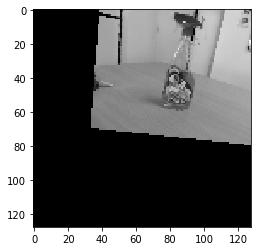

In [9]:
# store the first num_orig_img_train images to an array
# store the first num_orig_img_train labels to an array
for i in range(num_orig_img_train): 
    ifile = orig_arc.open(orig_fnames[i])
    img = Image.open(ifile)
    img = img.resize((w,h))
    img = np.array(img, dtype=np.float32)
    orig_imgs_train[i, :, :] = img   

orig_gt_train = orig_gt[:num_orig_img_train, :]
    
fig = plt.figure()
plt.imshow(orig_imgs_train[10,:,:])
print(orig_gt_train[10,:])

[ 0.04075915 -0.03980854 -0.02036931  0.18241736 -0.04671976 -0.17414533]


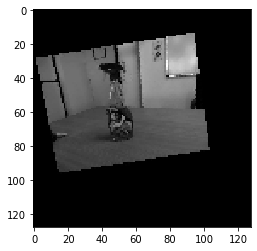

In [10]:
# store the first num_light_img_train images to array
# store the first num_light_img_train labels to array
for i in range(num_light_img_train):
    ifile = light_arc.open(light_fnames[i])
    img = Image.open(ifile)
    img = img.resize((w,h))
    img = np.array(img, dtype=np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    light_imgs_train[i, :, :] = img
    
light_gt_train = light_gt[:num_light_img_train, :]
    
fig = plt.figure()
plt.imshow(light_imgs_train[10,:,:])
print(light_gt_train[10,:])

[-0.00161385  0.00251123 -0.00460756  0.16142419 -0.04272844 -0.03493334]


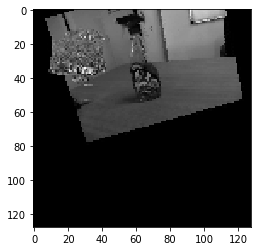

In [11]:
# store the first num_occl_img_train images to array
for i in range(num_occl_img_train):
    ifile = occl_arc.open(occl_fnames[i])
    img = Image.open(ifile)
    img = img.resize((w,h))
    img = np.array(img, dtype=np.float32)
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    occl_imgs_train[i, :, :] = img

occl_gt_train = occl_gt[:num_occl_img_train, :]
    
fig = plt.figure()
plt.imshow(occl_imgs_train[10,:,:])
print(occl_gt_train[10,:])

In [12]:
train_size = (num_light_img_train + num_occl_img_train + num_light_img_train + 
              num_light_img_train//2 + num_occl_img_train//2 + num_orig_img_train//2)
print(train_size)
train_A = np.zeros((train_size, w, h))
train_B = np.zeros((train_size, w, h))
train_A_gt = np.zeros((train_size, 6))
train_B_gt = np.zeros((train_size, 6))

print(train_A.shape)
print(train_B.shape)
print(train_A_gt.shape)
print(train_B_gt.shape)
cur_idx = 0

4949
(4949, 128, 128)
(4949, 128, 128)
(4949, 6)
(4949, 6)


In [13]:
# light perturbed and plain
half_size = num_light_img_train//2
rand_idx_orig = np.random.choice(np.arange(num_orig_img_train), size=num_light_img_train, replace=False)
rand_idx_light = np.random.choice(np.arange(num_light_img_train), size=num_light_img_train, replace=False)

train_A[cur_idx :cur_idx+half_size, :, :] = light_imgs_train[rand_idx_light[:half_size], :, :]
train_A_gt[cur_idx :cur_idx+half_size, :] = light_gt_train[rand_idx_light[:half_size], :]
train_B[cur_idx :cur_idx+half_size, :, :] = orig_imgs_train[rand_idx_orig[:half_size], :, :]
train_B_gt[cur_idx :cur_idx+half_size, :] = orig_gt_train[rand_idx_orig[:half_size], :]
cur_idx += half_size

train_A[cur_idx :cur_idx+half_size, :, :] = orig_imgs_train[rand_idx_orig[half_size:], :, :]
train_A_gt[cur_idx :cur_idx+half_size, :] = orig_gt_train[rand_idx_orig[half_size:], :]
train_B[cur_idx :cur_idx+half_size, :, :] = light_imgs_train[rand_idx_light[half_size:], :, :]
train_B_gt[cur_idx :cur_idx+half_size, :] = light_gt_train[rand_idx_light[half_size:], :]
cur_idx += half_size

In [14]:
# occlusion perturbed and plain
half_size = num_occl_img_train//2
rand_idx_orig = np.random.choice(np.arange(num_orig_img_train), size=num_occl_img_train, replace=False)
rand_idx_occl = np.random.choice(np.arange(num_occl_img_train), size=num_occl_img_train, replace=False)

train_A[cur_idx :cur_idx+half_size, :, :] = occl_imgs_train[rand_idx_occl[:half_size], :, :]
train_A_gt[cur_idx :cur_idx+half_size, :] = occl_gt_train[rand_idx_occl[:half_size], :]
train_B[cur_idx :cur_idx+half_size, :, :] = orig_imgs_train[rand_idx_orig[:half_size], :, :]
train_B_gt[cur_idx :cur_idx+half_size, :] = orig_gt_train[rand_idx_orig[:half_size], :]
cur_idx += half_size

train_A[cur_idx :cur_idx+half_size, :, :] = orig_imgs_train[rand_idx_orig[half_size:], :, :]
train_A_gt[cur_idx :cur_idx+half_size, :] = orig_gt_train[rand_idx_orig[half_size:], :]
train_B[cur_idx :cur_idx+half_size, :, :] = occl_imgs_train[rand_idx_occl[half_size:], :, :]
train_B_gt[cur_idx :cur_idx+half_size, :] = occl_gt_train[rand_idx_occl[half_size:], :]
cur_idx += half_size

In [15]:
# light perturbed and occlusion perturbed
half_size = num_occl_img_train//2
rand_idx_light = np.random.choice(np.arange(num_light_img_train), size=num_occl_img_train, replace=False)
rand_idx_occl = np.random.choice(np.arange(num_occl_img_train), size=num_occl_img_train, replace=False)

train_A[cur_idx :cur_idx+half_size, :, :] = light_imgs_train[rand_idx_light[:half_size], :, :]
train_A_gt[cur_idx :cur_idx+half_size, :] = light_gt_train[rand_idx_light[:half_size], :]
train_B[cur_idx :cur_idx+half_size, :, :] = occl_imgs_train[rand_idx_occl[:half_size], :, :]
train_B_gt[cur_idx :cur_idx+half_size, :] = occl_gt_train[rand_idx_occl[:half_size], :]
cur_idx += half_size

train_A[cur_idx :cur_idx+half_size, :, :] = occl_imgs_train[rand_idx_occl[half_size:], :, :]
train_A_gt[cur_idx :cur_idx+half_size, :] = occl_gt_train[rand_idx_occl[half_size:], :]
train_B[cur_idx :cur_idx+half_size, :, :] = light_imgs_train[rand_idx_light[half_size:], :, :]
train_B_gt[cur_idx :cur_idx+half_size, :] = light_gt_train[rand_idx_light[half_size:], :]
cur_idx += half_size

In [16]:
# light perturbed and light perturbed
half_size = num_light_img_train//2
rand_idx_light = np.random.choice(np.arange(num_light_img_train), size=num_light_img_train, replace=False)
train_A[cur_idx :cur_idx+half_size, :, :] = light_imgs_train[rand_idx_light[:half_size], :, :]
train_A_gt[cur_idx :cur_idx+half_size, :] = light_gt_train[rand_idx_light[:half_size], :]
train_B[cur_idx :cur_idx+half_size, :, :] = light_imgs_train[rand_idx_light[half_size:], :, :]
train_B_gt[cur_idx :cur_idx+half_size, :] = light_gt_train[rand_idx_light[half_size:], :]
cur_idx += half_size

In [17]:
# occlusion perturbed and occlusion perturbed
half_size = num_occl_img_train//2
rand_idx_occl = np.random.choice(np.arange(num_occl_img_train), size=num_occl_img_train, replace=False)
train_A[cur_idx :cur_idx+half_size, :, :] = occl_imgs_train[rand_idx_occl[:half_size], :, :]
train_A_gt[cur_idx :cur_idx+half_size, :] = occl_gt_train[rand_idx_occl[:half_size], :]
train_B[cur_idx :cur_idx+half_size, :, :] = occl_imgs_train[rand_idx_occl[half_size:], :, :]
train_B_gt[cur_idx :cur_idx+half_size, :] = occl_gt_train[rand_idx_occl[half_size:], :]
cur_idx += half_size

In [18]:
# orginal and original
half_size = num_orig_img_train//2
rand_idx_orig = np.random.choice(np.arange(num_orig_img_train), size=num_orig_img_train, replace=False)
train_A[cur_idx : cur_idx+half_size, :, :] = orig_imgs_train[rand_idx_orig[:half_size], :, :]
train_A_gt[cur_idx :cur_idx+half_size, :] = orig_gt_train[rand_idx_orig[:half_size], :]
train_B[cur_idx : cur_idx+half_size, :, :] = orig_imgs_train[rand_idx_orig[half_size:-1], :, :]
train_B_gt[cur_idx :cur_idx+half_size, :] = orig_gt_train[rand_idx_orig[half_size:-1], :]
cur_idx += half_size

In [19]:
print(cur_idx)

4949


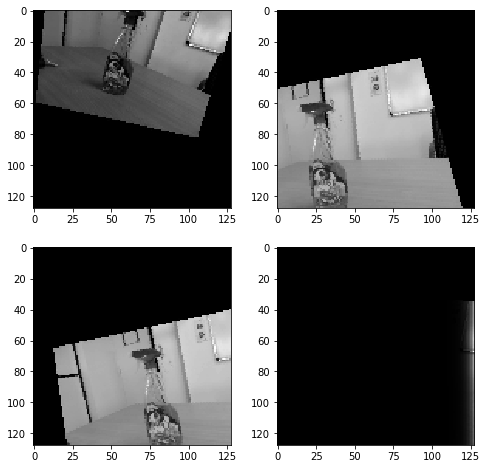

In [20]:
idx = 0
fig = plt.figure(figsize=(8,8))
fig.add_subplot(2, 2, 1)
plt.imshow(train_A[idx + num_light_img_train//2-10,:,:])
fig.add_subplot(2, 2, 2)
plt.imshow(train_B[idx + num_light_img_train//2-10,:,:])
fig.add_subplot(2, 2, 3)
plt.imshow(train_A[idx + num_light_img_train-10,:,:])
fig.add_subplot(2, 2, 4)
plt.imshow(train_B[idx + num_light_img_train-10,:,:])
idx += num_light_img_train

plt.show()

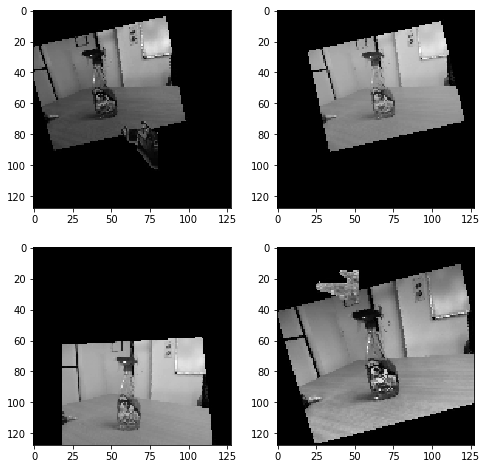

In [21]:
fig = plt.figure(figsize=(8,8))
fig.add_subplot(2, 2, 1)
plt.imshow(train_A[idx + num_occl_img_train//2-10,:,:])
fig.add_subplot(2, 2, 2)
plt.imshow(train_B[idx + num_occl_img_train//2-10,:,:])
fig.add_subplot(2, 2, 3)
plt.imshow(train_A[idx + num_occl_img_train-10,:,:])
fig.add_subplot(2, 2, 4)
plt.imshow(train_B[idx + num_occl_img_train-10,:,:])
idx += num_occl_img_train

plt.show()

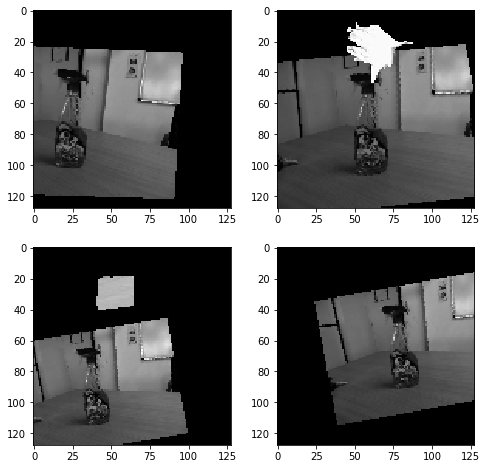

In [22]:
fig = plt.figure(figsize=(8,8))
fig.add_subplot(2, 2, 1)
plt.imshow(train_A[idx + num_occl_img_train//2-10,:,:])
fig.add_subplot(2, 2, 2)
plt.imshow(train_B[idx + num_occl_img_train//2-10,:,:])
fig.add_subplot(2, 2, 3)
plt.imshow(train_A[idx + num_occl_img_train-10,:,:])
fig.add_subplot(2, 2, 4)
plt.imshow(train_B[idx + num_occl_img_train-10,:,:])
idx += num_occl_img_train
plt.show()

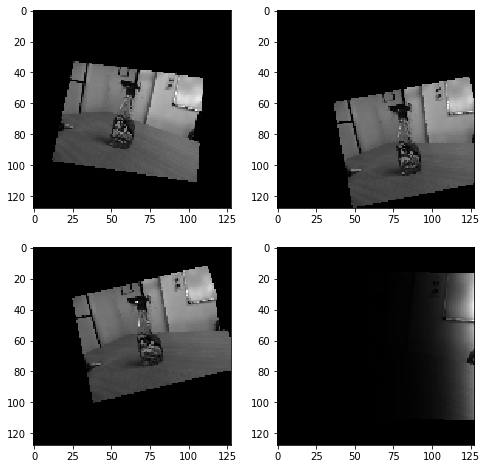

In [23]:
fig = plt.figure(figsize=(8,8))
fig.add_subplot(2, 2, 1)
plt.imshow(train_A[idx + num_light_img_train//4-10,:,:])
fig.add_subplot(2, 2, 2)
plt.imshow(train_B[idx + num_light_img_train//4-10,:,:])
fig.add_subplot(2, 2, 3)
plt.imshow(train_A[idx + num_light_img_train//2-10,:,:])
fig.add_subplot(2, 2, 4)
plt.imshow(train_B[idx + num_light_img_train//2-10,:,:])
idx += num_light_img_train//2
plt.show()

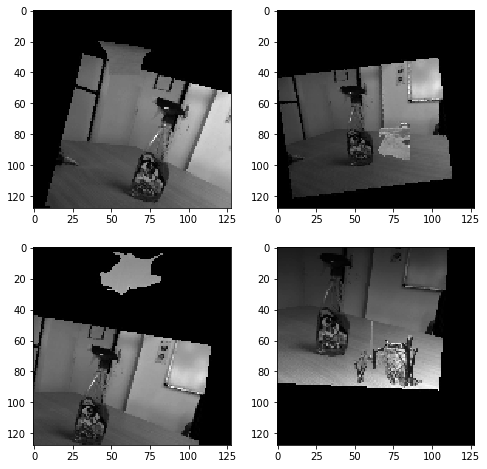

In [24]:
fig = plt.figure(figsize=(8,8))
fig.add_subplot(2, 2, 1)
plt.imshow(train_A[idx + num_occl_img_train//4 - 5,:,:])
fig.add_subplot(2, 2, 2)
plt.imshow(train_B[idx + num_occl_img_train//4 - 5,:,:])
fig.add_subplot(2, 2, 3)
plt.imshow(train_A[idx + num_occl_img_train//2 - 5,:,:])
fig.add_subplot(2, 2, 4)
plt.imshow(train_B[idx + num_occl_img_train//2 - 5,:,:])
idx += num_occl_img_train//2
plt.show()

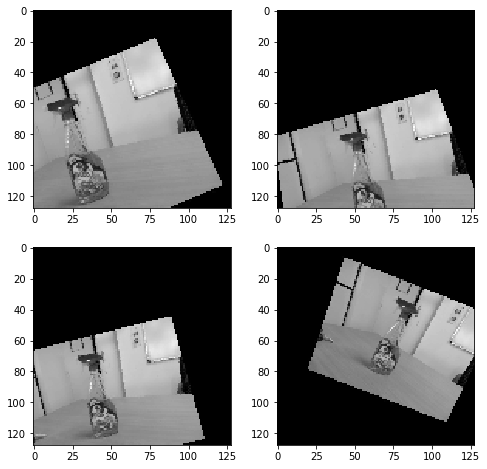

In [25]:
fig = plt.figure(figsize=(8,8))
fig.add_subplot(2, 2, 1)
plt.imshow(train_A[idx + num_orig_img_train//4 - 5,:,:])
fig.add_subplot(2, 2, 2)
plt.imshow(train_B[idx + num_orig_img_train//4 - 5,:,:])
fig.add_subplot(2, 2, 3)
plt.imshow(train_A[idx + num_orig_img_train//2 - 5,:,:])
fig.add_subplot(2, 2, 4)
plt.imshow(train_B[idx + num_orig_img_train//2 - 5,:,:])
idx += num_orig_img_train//2
plt.show()

In [26]:
rand_idx_final = np.random.choice(np.arange(train_size), size=train_size, replace=False)
train_A = train_A[rand_idx_final, :, :]
train_B = train_B[rand_idx_final, :, :]
train_A_gt = train_A_gt[rand_idx_final, :]
train_B_gt = train_B_gt[rand_idx_final, :]

In [27]:
h5_file_train = h5py.File(train_set_path, mode='w')
h5_file_gt = h5py.File(train_label_path, mode='w')

In [28]:
h5_file_train.create_dataset('train_images_A', data=train_A, dtype=np.float32)
h5_file_train.create_dataset('train_images_B', data=train_B, dtype=np.float32)
h5_file_gt.create_dataset('train_GT_A', data=train_A_gt, dtype=np.float32)
h5_file_gt.create_dataset('train_GT_B', data=train_B_gt, dtype=np.float32)

<HDF5 dataset "train_GT_B": shape (4949, 6), type "<f4">

In [29]:
h5_file_train.close()
h5_file_gt.close()

In [30]:
num_orig_test = len(orig_fnames) - num_orig_img_train
num_light_test = len(light_fnames) - num_light_img_train
num_occl_test = len(occl_fnames) - num_occl_img_train
test_size = num_orig_test + num_light_test + num_occl_test
print(test_size)

500


In [31]:
test_imgs = np.zeros((test_size, w, h))
test_gt = np.zeros((test_size, 6))
print(test_imgs.shape)
print(test_gt.shape)

(500, 128, 128)
(500, 6)


[ 0.01294995  0.0267833  -0.01434613  0.03391829  0.09330006 -0.18594274]


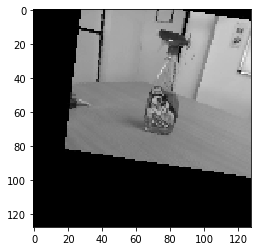

In [32]:
orig_imgs_test = np.zeros((num_orig_test, w, h))
for i in range(num_orig_img_train, len(orig_fnames)): 
    ifile = orig_arc.open(orig_fnames[i])
    img = Image.open(ifile)
    img = img.resize((w,h))
    img = np.array(img, dtype=np.float32)
    orig_imgs_test[i-num_orig_img_train, :, :] = img   

orig_gt_test = orig_gt[num_orig_img_train:, :]

fig = plt.figure()
plt.imshow(orig_imgs_test[10,:,:])
print(orig_gt_test[10,:])

[ 0.00342688 -0.0340439  -0.03824688  0.1808561  -0.12033736 -0.28640765]


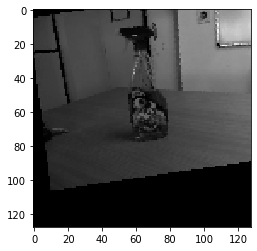

In [33]:
light_imgs_test = np.zeros((num_light_test, w, h))
for i in range(num_light_img_train, len(light_fnames)): 
    ifile = light_arc.open(light_fnames[i])
    img = Image.open(ifile)
    img = img.resize((w,h))
    img = np.array(img, dtype=np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    light_imgs_test[i-num_light_img_train, :, :] = img   

light_gt_test = light_gt[num_light_img_train:, :]

fig = plt.figure()
plt.imshow(light_imgs_test[10,:,:])
print(light_gt_test[10,:])

[-0.01055354  0.04276744  0.02083751 -0.19394927  0.03180816  0.00594159]


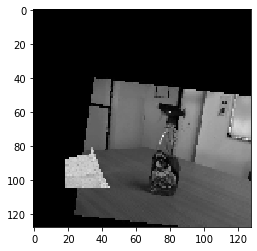

In [34]:
occl_imgs_test = np.zeros((num_occl_test, w, h))
for i in range(num_occl_img_train, len(occl_fnames)): 
    ifile = occl_arc.open(occl_fnames[i])
    img = Image.open(ifile)
    img = img.resize((w,h))
    img = np.array(img, dtype=np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    occl_imgs_test[i-num_occl_img_train, :, :] = img   

occl_gt_test = occl_gt[num_occl_img_train:, :]

fig = plt.figure()
plt.imshow(occl_imgs_test[10,:,:])
print(occl_gt_test[10,:])

In [35]:
test_imgs[:,:,:] = np.vstack((orig_imgs_test, light_imgs_test, occl_imgs_test))
test_gt[:,:] = np.vstack((orig_gt_test, light_gt_test, occl_gt_test))

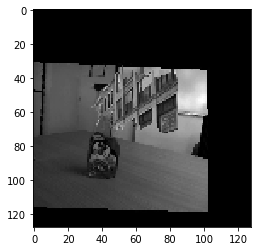

In [36]:
plt.imshow(test_imgs[450, :, :])

In [37]:
rand_idx_final = np.random.choice(np.arange(test_size), size=test_size, replace=False)
test_imgs = test_imgs[rand_idx_final, :, :]
test_gt = test_gt[rand_idx_final, :,]

In [38]:
h5_file_test = h5py.File(test_set_path, mode='w')
h5_file_test.create_dataset('test_images', data=test_imgs, dtype=np.float32)
h5_file_test.close()

np.savetxt(test_label_path, test_gt)